In [1]:
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# Importing Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import warnings
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


### creating Instances

mnb = MultinomialNB()
rfc = RandomForestClassifier()
ps = PorterStemmer()
encoder = LabelEncoder()
cv = CountVectorizer()
mnb = MultinomialNB()
rfc = RandomForestClassifier()
warnings.filterwarnings('ignore')

# Loading Datasets

In [3]:
train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
val_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

**Adding column names**

In [4]:
train_df.columns = ['id','Entity','Sentiment','Tweet']
val_df.columns = ['id','Entity','Sentiment','Tweet']

In [5]:
train_df['Entity'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [6]:
print(train_df['Sentiment'].unique())
print(val_df['Sentiment'].unique())

['Positive' 'Neutral' 'Negative' 'Irrelevant']
['Neutral' 'Negative' 'Positive' 'Irrelevant']


# Concatinating training and validation datasets

In [7]:
data = pd.concat([train_df,val_df],ignore_index = True)

In [8]:
data.shape

(75680, 4)

In [9]:
data = data.dropna() ## drpping null values

In [10]:
data.isnull().sum()

id           0
Entity       0
Sentiment    0
Tweet        0
dtype: int64

In [11]:
data.duplicated().sum() ### checking for duplicates

2856

In [12]:
data = data.drop_duplicates(keep = 'first') ## dropping duplicates

In [13]:
data.duplicated().sum()

0

In [14]:
data.info() ## checking type of attributes

<class 'pandas.core.frame.DataFrame'>
Index: 72138 entries, 0 to 75676
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         72138 non-null  int64 
 1   Entity     72138 non-null  object
 2   Sentiment  72138 non-null  object
 3   Tweet      72138 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


**As id is an identifier which is used to classify each item uniquely in these analysis we have index we dont want these column for now and Entity represents the keywords in tweet these might not an important column**

**Dropping ID and Entity**

In [15]:
data = data.drop(columns = ['id','Entity'])

In [16]:
target_counts = data['Sentiment'].value_counts()

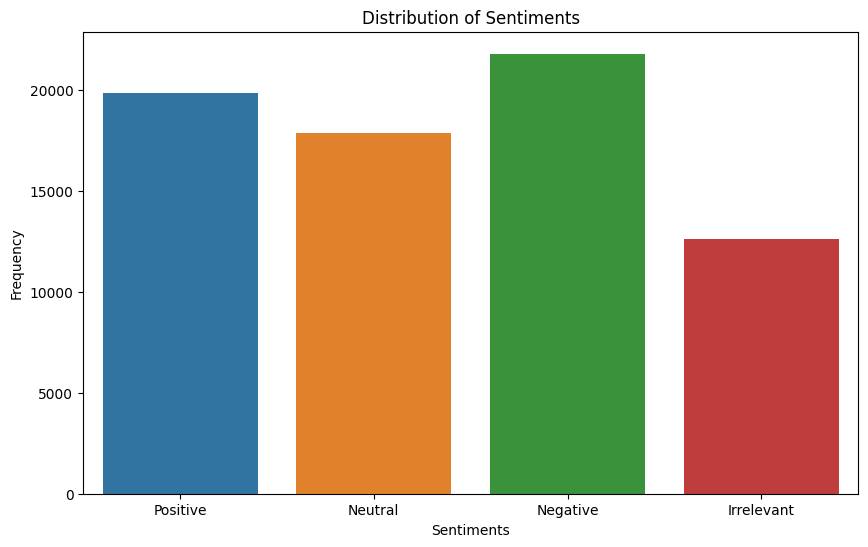

In [17]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'Sentiment',data = data)
plt.title('Distribution of Sentiments')
plt.xlabel ('Sentiments')
plt.ylabel('Frequency')
plt.show()

In [18]:
from nltk.corpus import stopwords                   #### importing stopwords
stop_wrds =  stopwords.words('english')             ### creating instances for stopwords and punctuations
punctuations = string.punctuation

In [19]:
data.head(3)

Sentiment                                              Tweet
0  Positive  I am coming to the borders and I will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...

# Defining a Function that Transforms Text

In [20]:
def transform_text(text):         
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stop_wrds and i not in punctuations:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [21]:
data['cleaned_tweet'] = data['Tweet'].apply(transform_text)

# Function to remove emojis

In [28]:
import re
def remove_emojis(text):
    if not isinstance(text, str):
        return text
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # other emojis
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [29]:
data['cleaned_tweet']=data['cleaned_tweet'].apply(remove_emojis)

In [30]:
data = data.drop(columns = ['Tweet'])   ### dropping original column of tweet

# Label Encoding

In [31]:
data['Sentiment'] = encoder.fit_transform(data['Sentiment'])

In [32]:
data['Sentiment'].value_counts() ### 1 - Negative
                                 ### 2 - Neutral
                                 ### 3 - Positive
                                 ### 4 - Irrelevant

Sentiment
1    21790
3    19845
2    17879
0    12624
Name: count, dtype: int64

# Visualizing the most common words using the WordCloud

In [33]:
wc = WordCloud(width = 500,height = 500,background_color = 'white')

In [34]:
neg_wc = wc.generate(data[data['Sentiment']==1]['cleaned_tweet'].str.cat(sep = " "))
plt.imshow(neg_wc)

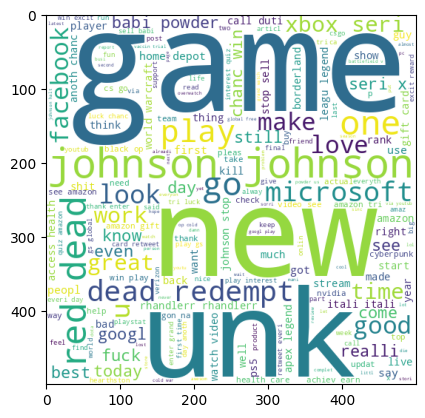

In [35]:
neu_wc = wc.generate(data[data['Sentiment']==2]['cleaned_tweet'].str.cat(sep = " "))
plt.imshow(neu_wc)

In [36]:
pos_wc = wc.generate(data[data['Sentiment']==3]['cleaned_tweet'].str.cat(sep = " "))
plt.imshow(pos_wc)

In [37]:
irr_wc = wc.generate(data[data['Sentiment']==0]['cleaned_tweet'].str.cat(sep=" "))
plt.imshow(irr_wc)

# creating corpus to each sentiment

In [133]:
neg_corpus = []
for i in data[data['Sentiment']==1]['cleaned_tweet'].tolist():
    for words in i.split():
        neg_corpus.append(words)
print(len(neg_corpus))

neu_corpus = []
for i in data[data['Sentiment']==2]['cleaned_tweet'].tolist():
    for words in i.split():
        neu_corpus.append(words)
print(len(neu_corpus))

pos_corpus = []
for i in data[data['Sentiment']==3]['cleaned_tweet'].tolist():
    for words in i.split():
        pos_corpus.append(words)
print(len(pos_corpus))

irr_corpus = []
for i in data[data['Sentiment']==0]['cleaned_tweet'].tolist():
    for words in i.split():
        irr_corpus.append(words)
len(irr_corpus)


240473
202671
191714


135174

# Visualizing the most commonly occured words

In [140]:
negative_word_count = Counter(neg_corpus).most_common(30)
negative_word_table = pd.DataFrame(negative_word_count,columns = ['word','count'])
plt.figure(figsize = (10,6))
sns.barplot(x = 'word',y='count',data = negative_word_table)
plt.title("Counter of Negative corpus plot")
plt.xlabel('words')
plt.ylabel('count')
plt.xticks(rotation = 'vertical')
plt.show()

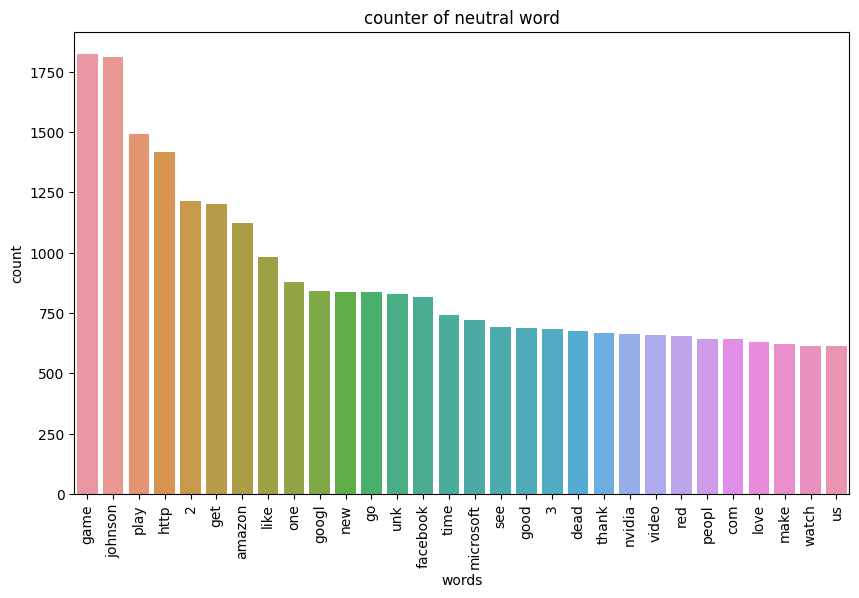

In [148]:
neutral_word_count = Counter(neu_corpus).most_common(30)
neutral_word_table = pd.DataFrame(neutral_word_count,columns = ['word','count'])
plt.figure(figsize = (10,6))
sns.barplot(x = 'word',y = 'count',data =neutral_word_table )
plt.title("counter of neutral word")
plt.xlabel('words')
plt.ylabel('count')
plt.xticks(rotation = 'vertical')
plt.show()

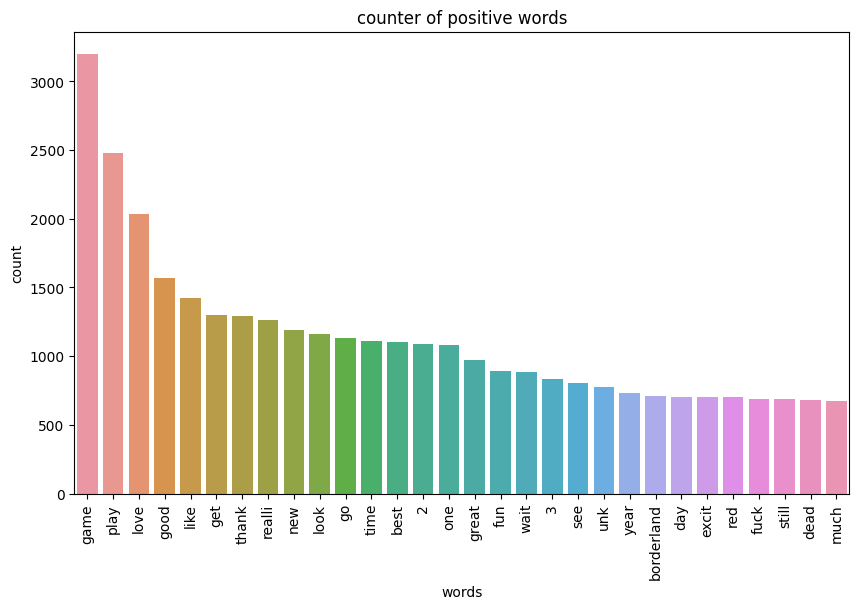

In [149]:
positive_word_count = Counter(pos_corpus).most_common(30)
postive_word_table = pd.DataFrame(positive_word_count,columns = ['word','count'])
plt.figure(figsize = (10,6))
sns.barplot(x = 'word',y = 'count',data =postive_word_table )
plt.title('counter of positive words')
plt.xlabel('words')
plt.ylabel('count')
plt.xticks(rotation = 'vertical')
plt.show()

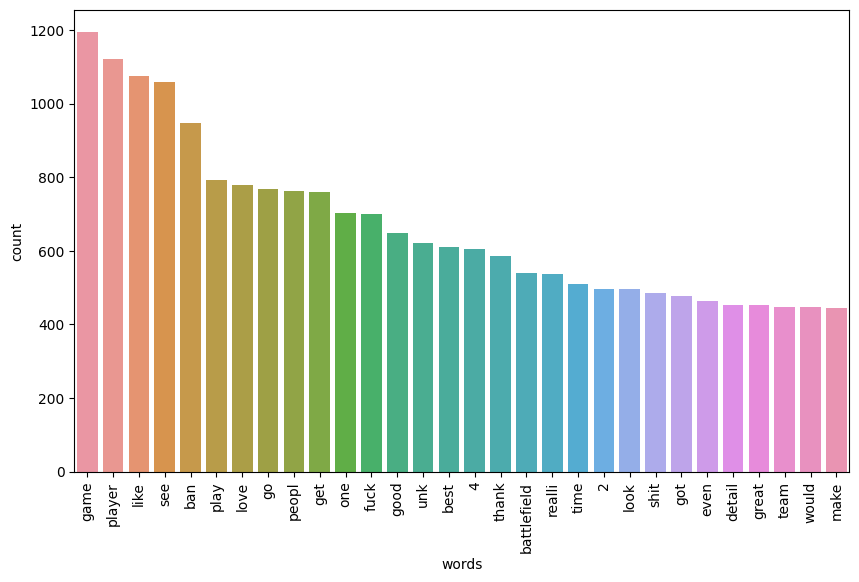

In [151]:
irrelevant_word_count = Counter(irr_corpus).most_common(30)
irrelevant_word_table = pd.DataFrame(irrelevant_word_count,columns = ['word','count'])
plt.figure(figsize = (10,6))
sns.barplot(x = 'word',y = 'count',data = irrelevant_word_table )
plt.xlabel('words')
plt.ylabel('count')
plt.xticks(rotation = 'vertical')
plt.show()

**Transforming the tweets using countvectorizer and converting it to array**

In [38]:
X = cv.fit_transform(data['cleaned_tweet']).toarray() 

In [39]:
X.shape

(72138, 23426)

In [40]:
y = data['Sentiment'].values

In [41]:
y

array([3, 3, 3, ..., 2, 0, 0])

**splitting the data into train an test datasets**

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 24,test_size = 0.3)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50496, 23426)
(50496,)
(21642, 23426)
(21642,)


In [177]:
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7033083818501062
[[2115  693  260  695]
 [ 200 5304  390  647]
 [ 259  994 3151  885]
 [ 174  824  400 4651]]


In [179]:
rfc.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7033083818501062
[[2115  693  260  695]
 [ 200 5304  390  647]
 [ 259  994 3151  885]
 [ 174  824  400 4651]]


# **Try to run these cells**

In [4]:
clfs = {'SVC' : svc,
    'KN' : knc, 
    'MNB': mnb, 
     'BNB':bnb,
     'GNB':gnb,
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb}

In [5]:
def train_classifier(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [ ]:
train_classifier(svc,X_train,X_test,y_train,y_test)